In [42]:
%load_ext autoreload
%autoreload 2

import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [43]:
# load local model file and initialize model class
from model import ModelClass
model = ModelClass() # set a few number of periods.


par = model.par
sol = model.sol
sim = model.sim

In [44]:
par.opt_method = 'Nelder-Mead'
par.opt_tol = 1e-6
par.opt_maxiter = 1000

%time model.solve()

We are in t = 69
We are in t = 68
We are in t = 67
We are in t = 66


c:\Users\peter\Speciale\Design_retirement\model.py:155: OptimizeWarning: Initial guess is not within the specified bounds
  sol.c[idx] = result.x[0]


We are in t = 65
We are in t = 64
We are in t = 63
We are in t = 62
We are in t = 61
We are in t = 60
We are in t = 59
We are in t = 58
We are in t = 57
We are in t = 56
We are in t = 55
We are in t = 54
We are in t = 53
We are in t = 52
We are in t = 51
We are in t = 50
We are in t = 49
We are in t = 48
We are in t = 47
We are in t = 46
We are in t = 45
We are in t = 44
We are in t = 43
We are in t = 42
We are in t = 41
We are in t = 40
We are in t = 39
We are in t = 38
We are in t = 37
We are in t = 36
We are in t = 35
We are in t = 34
We are in t = 33
We are in t = 32
We are in t = 31
We are in t = 30
We are in t = 29
We are in t = 28
We are in t = 27
We are in t = 26
We are in t = 25
We are in t = 24
We are in t = 23
We are in t = 22
We are in t = 21
We are in t = 20
We are in t = 19
We are in t = 18
We are in t = 17
We are in t = 16
We are in t = 15
We are in t = 14
We are in t = 13
We are in t = 12
We are in t = 11
We are in t = 10
We are in t = 9
We are in t = 8
We are in t = 7


In [45]:
%time model.simulate_prep()
%time model.simulate()

CPU times: total: 0 ns
Wall time: 0 ns
CPU times: total: 0 ns
Wall time: 2.03 ms


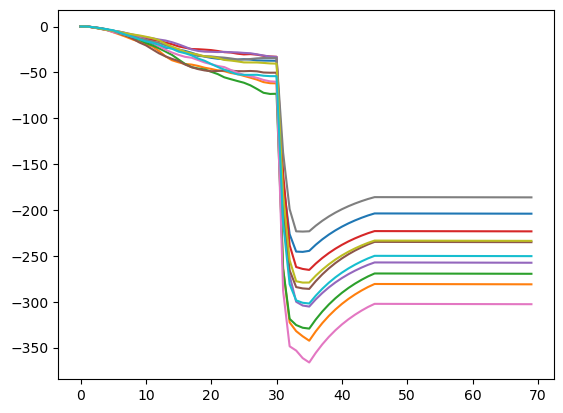

In [55]:
plt.plot(np.arange(par.T),model.sim.a.T)


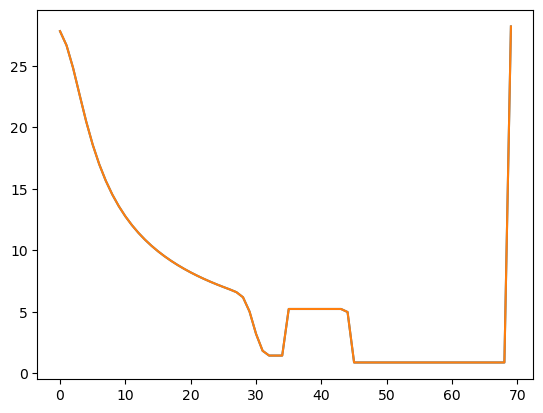

In [41]:
for i in range(sol.V.shape[3]):
    plt.plot(np.arange(par.T),sol.c[:, 1, 1, i])


In [45]:
sol.V[:, 4, 4, :]

array([[-5.58507483e-04, -1.45445881e-04, -1.47102609e-04,
        -8.37965701e-04, -5.56798648e-04],
       [-5.58888699e-04, -1.45919642e-04, -1.47573695e-04,
        -8.38186985e-04, -5.57012755e-04],
       [-5.59524687e-04, -1.46711618e-04, -1.48361414e-04,
        -8.38554512e-04, -5.57370045e-04],
       [-5.60417449e-04, -1.47825016e-04, -1.49469244e-04,
        -8.39070597e-04, -5.57872326e-04],
       [-5.61569661e-04, -1.49264114e-04, -1.50901827e-04,
        -8.39738349e-04, -5.58522016e-04],
       [-5.62984759e-04, -1.51034418e-04, -1.52665132e-04,
        -8.40561760e-04, -5.59322330e-04],
       [-5.64666970e-04, -1.53142712e-04, -1.54766496e-04,
        -8.41545750e-04, -5.60277327e-04],
       [-5.66621391e-04, -1.55597192e-04, -1.57214771e-04,
        -8.42696252e-04, -5.61392081e-04],
       [-5.68854097e-04, -1.58407659e-04, -1.60020510e-04,
        -8.44020335e-04, -5.62672897e-04],
       [-5.71372285e-04, -1.61585765e-04, -1.63196216e-04,
        -8.45526358e-04

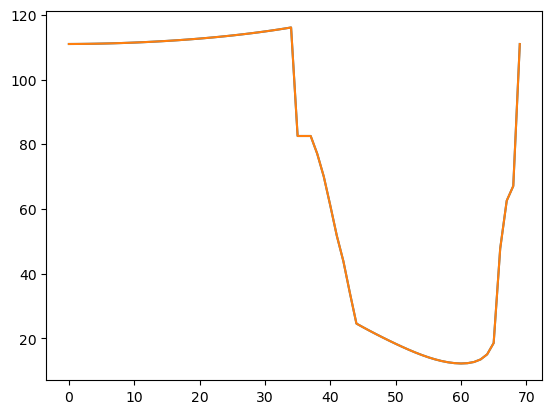

In [9]:
for i in range(sol.V.shape[3]):
    plt.plot(np.arange(par.T),sol.c[:, 4, 4, i])

In [152]:
sol.V[:-1, 4, 4, 4]-sol.V[1:, 4, 4, 4]

IndexError: index 4 is out of bounds for axis 3 with size 2

<>:22: SyntaxWarning: invalid escape sequence '\s'
<>:28: SyntaxWarning: invalid escape sequence '\s'
<>:22: SyntaxWarning: invalid escape sequence '\s'
<>:28: SyntaxWarning: invalid escape sequence '\s'
C:\Users\peter\AppData\Local\Temp\ipykernel_24144\2554536382.py:22: SyntaxWarning: invalid escape sequence '\s'
  ax.set(xlabel='Liquid assets, $a_{T}$', ylabel='Illiquid assets, $s_T$', zlabel='Consumption, $c_{T}^{\star}$', title=f'Consumption at $k_T = {k_fixed:.2f}$')
C:\Users\peter\AppData\Local\Temp\ipykernel_24144\2554536382.py:28: SyntaxWarning: invalid escape sequence '\s'
  ax.set(xlabel='Liquid assets, $a_{T}$', ylabel='Illiquid assets, $s_T$', zlabel='Hours, $h_{T}^{\star}$', title=f'Labor Supply at $k_T = {k_fixed:.2f}$')


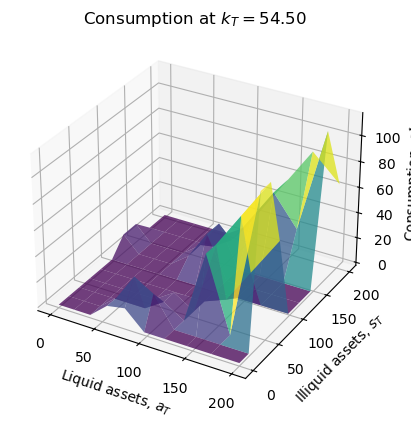

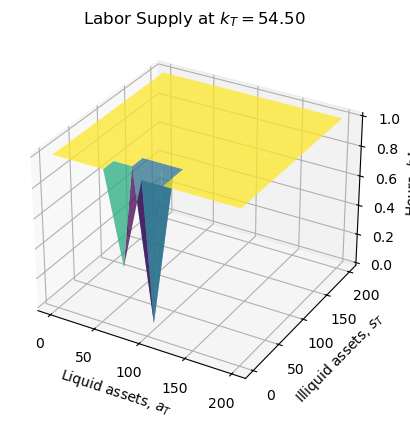

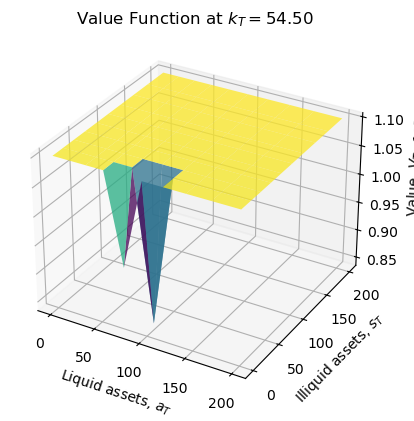

In [126]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Choose a fixed k index (e.g., middle of the k_grid)
k_idx = 2
k_fixed = par.k_grid[k_idx]  

# Extract the meshgrid for plotting
a_mesh, s_mesh = np.meshgrid(par.a_grid, par.s_grid, indexing='ij')

# Extract solutions at time t and fixed k
t = 30
c_plot = sol.c[t, :, :, k_idx]  # Fix k_idx
h_plot = sol.h[t, :, :, k_idx]
V_plot = sol.V[t, :, :, k_idx]

# Plot consumption
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(a_mesh, s_mesh, c_plot, rstride=1, cstride=1, cmap='viridis', edgecolor='none', alpha=0.75)
ax.set(xlabel='Liquid assets, $a_{T}$', ylabel='Illiquid assets, $s_T$', zlabel='Consumption, $c_{T}^{\star}$', title=f'Consumption at $k_T = {k_fixed:.2f}$')

# Plot labor supply
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(a_mesh, s_mesh, h_plot, rstride=1, cstride=1, cmap='viridis', edgecolor='none', alpha=0.75)
ax.set(xlabel='Liquid assets, $a_{T}$', ylabel='Illiquid assets, $s_T$', zlabel='Hours, $h_{T}^{\star}$', title=f'Labor Supply at $k_T = {k_fixed:.2f}$')

# Plot value function
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(a_mesh, s_mesh, V_plot, rstride=1, cstride=1, cmap='viridis', edgecolor='none', alpha=0.75)
ax.set(xlabel='Liquid assets, $a_{T}$', ylabel='Illiquid assets, $s_T$', zlabel='Value, $V_{T}$', title=f'Value Function at $k_T = {k_fixed:.2f}$')

plt.show()
